In [2]:
import pandas as pd
import numpy as np
from scipy import sparse as sps
import nltk
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import lenskit
import lenskit.crossfold as xf
from  lenskit.crossfold import TTPair

In [4]:
from lenskit.algorithms import als, basic, item_knn, user_knn
from lenskit.algorithms.basic import Fallback
from lenskit.algorithms.als import BiasedMF, ImplicitMF
from lenskit.algorithms.implicit import BPR

In [5]:
from lenskit.batch import MultiEval
from lenskit.crossfold import partition_users, SampleN
from lenskit import batch, topn, util
from tf_idf import tf_idf

In [6]:
saved = open("pickle/game_reviews.pickle","rb")
game_reviews = pickle.load(saved)
game_reviews.head()

,funny,helpful,item_id,last_edited,posted,recommend,review,user_id
0,,No ratings yet,1250,,"Posted November 5, 2011.",True,Simple yet with great replayability. In my opi...,76561197970982479
1,,No ratings yet,22200,,"Posted July 15, 2011.",True,It's unique and worth a playthrough.,76561197970982479
2,,No ratings yet,43110,,"Posted April 21, 2011.",True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479
3,,15 of 20 people (75%) found this review helpful,251610,,"Posted June 24, 2014.",True,I know what you think when you see this title ...,js41637
4,,0 of 1 people (0%) found this review helpful,227300,,"Posted September 8, 2013.",True,For a simple (it's actually not all that simpl...,js41637


In [7]:
game_reviews.head()

,funny,helpful,item_id,last_edited,posted,recommend,review,user_id
0,,No ratings yet,1250,,"Posted November 5, 2011.",True,Simple yet with great replayability. In my opi...,76561197970982479
1,,No ratings yet,22200,,"Posted July 15, 2011.",True,It's unique and worth a playthrough.,76561197970982479
2,,No ratings yet,43110,,"Posted April 21, 2011.",True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479
3,,15 of 20 people (75%) found this review helpful,251610,,"Posted June 24, 2014.",True,I know what you think when you see this title ...,js41637
4,,0 of 1 people (0%) found this review helpful,227300,,"Posted September 8, 2013.",True,For a simple (it's actually not all that simpl...,js41637


In [8]:
#game_reviews['review'] = game_reviews['review'].applymap(str)
#game_reviews['review'] = game_reviews['review'].astype(str)

In [9]:
user_game = open("pickle/user_games.pickle","rb")
user_games = pickle.load(user_game)
user_games.head()

,user_id,item_id,item_name
0,76561197970982479,10,Counter-Strike
1,76561197970982479,20,Team Fortress Classic
2,76561197970982479,30,Day of Defeat
3,76561197970982479,40,Deathmatch Classic
4,76561197970982479,50,Half-Life: Opposing Force


In [10]:
#user_games[user_games['item_id']>50]

In [11]:
user_games = user_games.rename(columns={'user_id': 'user', 'item_id': 'item'})
user_games_list = user_games[['item', 'user']]
user_games_list.head()

,item,user
0,10,76561197970982479
1,20,76561197970982479
2,30,76561197970982479
3,40,76561197970982479
4,50,76561197970982479


In [12]:
reviews = game_reviews[['item_id', 'user_id','review']]
reviews = reviews.rename(columns={'user_id': 'user', 'item_id': 'item'})
reviews.shape

(58430, 3)

In [13]:
reviews.tail()

,item,user,review
58425,70,76561198312638244,a must have classic from steam definitely wort...
58426,362890,76561198312638244,this game is a perfect remake of the original ...
58427,273110,LydiaMorley,had so much fun plaing this and collecting res...
58428,730,LydiaMorley,:D
58429,440,LydiaMorley,so much fun :D


### join user-item and reviws

In [14]:
rev_item = set(reviews['item'])
user_item = set(user_games['item'])
item_butNot_rev = user_item.intersection(rev_item) ## items that have reviews

### taking only reviwed item

In [15]:
user_item_rev = user_games_list[user_games_list['item'].isin(list(item_butNot_rev))] 
user_item_rev.head()

,item,user
0,10,76561197970982479
1,20,76561197970982479
2,30,76561197970982479
3,40,76561197970982479
4,50,76561197970982479


In [16]:
result = pd.merge(user_item_rev, reviews, how = 'outer', on=['item', 'user'])
result.shape

(4219381, 3)


# Analysis

### so every item in result data has reviews but not every user is a reviwer

In [17]:
result.nunique()

item       3682
user      71856
review    55312
dtype: int64

In [18]:
reviews.nunique()

item       3682
user      25457
review    55312
dtype: int64

## Pruning

## removing less than 5 items holder

### item count and remove user less than (n)

In [19]:
def groupby_count(df, group, count):
    game_count = pd.DataFrame()
    game_count['count'] = df.groupby(group)[count].nunique()
    return game_count

In [20]:
def prune(df, condition):     ## returns a dataframe that meet the given condition
    user_n = df.loc[df['count'] < condition ]
    return user_n

In [21]:
game_count = groupby_count(result, 'user', 'item')
game_count.sort_values(by = 'count', ascending = False).head()

,count
user,
phrostb,2698
chidvd,2514
piepai,2419
thugnificent,2373
DeEggMeister,1914


In [22]:
user_5 = prune(game_count, 5)

In [23]:
user_less_5 = user_5.index
user_less_5

Index(['001002130882', '00284702', '010195345', '0102705195',
       '011111135489484797', '0132489', '025652', '03375616256', '0445233',
       '07824',
       ...
       'zellenal', 'zeronacho', 'zielinskak40', 'ziko21', 'zillarino',
       'zimbalor', 'zixwot', 'zombifiedddd', 'zraicis', 'zzonci'],
      dtype='object', name='user', length=9833)

In [24]:
pruned_data_5 = result.set_index('user').drop(user_less_5)
pruned_data_5.reset_index(inplace = True)
pruned_data_5.head()

,user,item,review
0,76561197970982479,10,NaN
1,76561197970982479,20,NaN
2,76561197970982479,30,NaN
3,76561197970982479,40,NaN
4,76561197970982479,50,NaN


## Analysis

#### 13% of users are missed

In [24]:
#len(prune(game_count, 2))  ## users that have 1 items in library
pruned_user_len = len(prune(game_count, 5))/result['user'].nunique()
pruned_user_len

0.13684313070585616

#### .5% items are missed

In [25]:
reviews.nunique()

item       3682
user      25457
review    55312
dtype: int64

In [26]:
pruned_data_5.nunique()

user      62023
item       3663
review    51269
dtype: int64

In [27]:
pruned_item = result['item'].nunique()-pruned_data_5['item'].nunique()
pruned_item_frac = pruned_item/result['item'].nunique()
pruned_item_frac

0.005160239000543183

#### 7% reviews are missed

In [28]:
pruned_rev = result['review'].nunique()-pruned_data_5['review'].nunique()
pruned_rev_frac = pruned_rev/result['review'].nunique()
pruned_rev_frac

0.07309444605148974

## check user item

In [29]:
pruned_data_5.loc[pruned_data_5['user'] == 'kenkaniff']

,user,item,review
4196366,kenkaniff,42680,This is honestly the worst Call of Duty ever. ...
4196367,kenkaniff,242050,Great game! Recommend it!
4196368,kenkaniff,209160,Not that great of a game actually! The multipl...
4196369,kenkaniff,8190,This is one of my favourite games! It is reall...
4196370,kenkaniff,24240,"Love it, can't stop playing it!!"


In [30]:
only_rev = pruned_data_5.dropna()

In [31]:
item_data1 = pd.DataFrame({'review': only_rev.groupby(['item']).review.apply(lambda x:' '.join(x))})
item_data1.reset_index(inplace=True)

## Partition by user

In [22]:
file = open("pairs_user_new.pickle","rb")
pairs_user = pickle.load(file)

In [23]:
truth = pd.concat((p.test for p in pairs_user))

In [24]:
truth.shape

(62023, 3)

In [28]:
truth[truth['user']=='-2SV-vuLB-Kg']

,user,item,review
3197437,-2SV-vuLB-Kg,4720,NaN


## Evaluation

In [36]:
def algo_eval(path, algo, dataset):
    evaluation = batch.MultiEval(path=path, predict=False, recommend=True)
    evaluation.add_algorithms(algos=algo)
    evaluation.add_datasets(data=dataset)
    evaluation.run()

In [37]:
def ndcg(file_name, truth):
    recs = pd.read_parquet(file_name)
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    ndcg = rla.compute(recs, truth)
    return ndcg

In [38]:
def RR(recs, truth):
    #recs = pd.read_parquet(file_name)
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.recip_rank)
    RR = rla.compute(recs, truth)
    return RR

In [14]:
from fastparquet import ParquetFile
result_test = pd.DataFrame()
#df.to_parquet(tmp_file, engine='pyarrow', compression='gzip')
pf = ParquetFile('results/steam/pruned_5_new/recommendations.parquet')
for df in pf.iter_row_groups():
    a = df.loc[df['rank']<101]
    result_test = result_test.append(a,sort = False)
    #print(a.head(n=10))

In [16]:
result_test.to_parquet('results/steam/pruned_5_new/recs100.parquet')
result_test.to_csv("results/steam/pruned_5_new/recs100.csv")

/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


In [20]:
result_test['RunId'].nunique()

25

In [27]:
def RR(rec, truth):
    #recs = pd.read_parquet(file_name)
    #recs = rec
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.recip_rank)
    RR_result = rla.compute(rec, truth)
    return RR_result

RR_algo_comp = RR(result_test, truth)

/home/amifaraj/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [28]:
RR_algo_comp.to_parquet('results/steam/pruned_5_new/RR100.parquet')
RR_algo_comp.to_csv("results/steam/pruned_5_new/RR100.csv")

/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


In [36]:
legend = pd.read_csv("results/steam/pruned_5_new/runs.csv")
legend = legend.set_index('RunId').loc[:,'AlgoStr']

RR_algo = RR_algo_comp.join(legend, on='RunId')

RR_algo.to_parquet('results/steam/pruned_5_new/RR_algo100.parquet')
RR_algo.to_csv("results/steam/pruned_5_new/RR_algo100.csv")

/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


In [30]:
RR_algo.head()

recip_rank                                            AlgoStr
user    RunId                                                               
--000-- 11       0.000000                                             Tf-IDF
        12       0.031250                     ItemItem(nnbrs=20, msize=None)
        13       0.029412                                            Popular
        14       0.071429         als.ImplicitMF(features=40, reg=0.1, w=40)
        15       0.015873  Implicit(<implicit.bpr.BayesianPersonalizedRan...

In [32]:
RR_algo.reset_index(inplace = True)
MRR_by_algo = pd.DataFrame(RR_algo.groupby(['AlgoStr']).recip_rank.mean())
MRR_by_algo.reset_index(inplace = True)
MRR_by_algo

,AlgoStr,recip_rank
0,Implicit(<implicit.bpr.BayesianPersonalizedRan...,0.145532
1,"ItemItem(nnbrs=20, msize=None)",0.151171
2,Popular,0.093430
3,Tf-IDF,0.052362
4,"als.ImplicitMF(features=40, reg=0.1, w=40)",0.107147


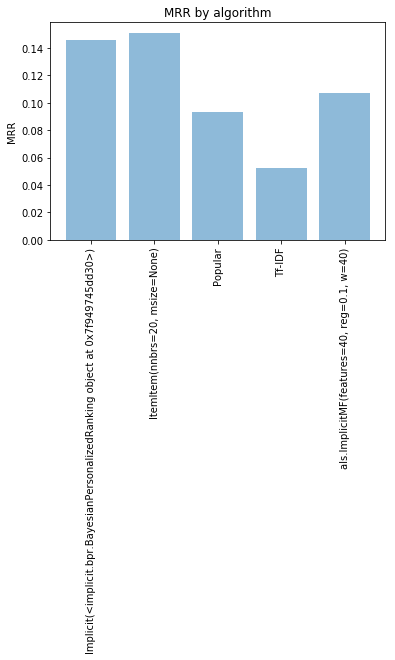

In [35]:
import numpy as np
import matplotlib.pyplot as plt

X = MRR_by_algo['AlgoStr']
Y = MRR_by_algo['recip_rank']


plt.bar(X,Y, align='center', alpha=0.5)
plt.xlabel = ('Algorithm')
plt.xticks(rotation=90)
plt.ylabel('MRR')
plt.title('MRR by algorithm')

plt.show()

In [40]:
recs = pd.read_csv('results/steam/pruned_5_new/recs.csv')
recs.shape

(310115, 4)

In [40]:
recs.drop(columns = ['Unnamed: 0'], inplace = True)

In [33]:
result['user'].nunique()

62023

In [58]:
#recs[5000:10000].head()

,item,score,user,rank,RunId
5000,49520,4.625439,-iBubble,1,1
5001,239820,4.619436,-iBubble,2,1
5002,207610,4.422115,-iBubble,3,1
5003,4000,4.386938,-iBubble,4,1
5004,204360,4.340590,-iBubble,5,1


In [1]:
user = recs[recs['user']=='765611980577']

NameError: name 'recs' is not defined

In [42]:
truth['user'].nunique()

62023

In [44]:
recs.head()

,item,score,user,rank,RunId
0,239820,10.878623,-2SV-vuLB-Kg,1,1
1,49520,10.565837,-2SV-vuLB-Kg,2,1
2,208090,10.410738,-2SV-vuLB-Kg,3,1
3,304930,10.243493,-2SV-vuLB-Kg,4,1
4,243870,10.159557,-2SV-vuLB-Kg,5,1


In [47]:
legend = pd.read_csv("results/steam/pruned_5_new/runs.csv")
legend = legend.set_index('RunId').loc[:,'AlgoStr']

In [48]:
rec_algo = recs.join(legend, on='RunId')
rec_algo.head(15)

,item,score,user,rank,RunId,AlgoStr
0,239820,10.878623,-2SV-vuLB-Kg,1,1,Tf-IDF
1,49520,10.565837,-2SV-vuLB-Kg,2,1,Tf-IDF
2,208090,10.410738,-2SV-vuLB-Kg,3,1,Tf-IDF
3,304930,10.243493,-2SV-vuLB-Kg,4,1,Tf-IDF
4,243870,10.159557,-2SV-vuLB-Kg,5,1,Tf-IDF
5,113200,10.110414,-2SV-vuLB-Kg,6,1,Tf-IDF
6,301520,10.104972,-2SV-vuLB-Kg,7,1,Tf-IDF
7,207610,9.994515,-2SV-vuLB-Kg,8,1,Tf-IDF
8,204360,9.979526,-2SV-vuLB-Kg,9,1,Tf-IDF
9,200210,9.945879,-2SV-vuLB-Kg,10,1,Tf-IDF


In [57]:
rec_algo['user'].nunique()

21305

In [59]:
truth['user'].nunique()

62023

In [58]:
pruned_data_5['user'].nunique()

62023

In [17]:
rec_algo[rec_algo['AlgoStr']=='Tf-IDF'].shape

(20839928, 6)

In [26]:
a = set(truth['user'])
b = set(result_test['user'])
gadha = a.difference(b)
gadha

set()

In [70]:
check = pruned_data_5.set_index('user')
user_check = check.loc[gadha]
user_check.reset_index(inplace = True)
groupby_count(user_check, 'user', 'item').sort_values(by='count', ascending = False)

,count
user,
phrostb,2698
chidvd,2514
piepai,2419
thugnificent,2373
DeEggMeister,1914
Steamified,1908
mayshowganmore,1848
rawrvixen,1782
fearlesskeeper,1750


In [71]:
rec_algo['AlgoStr'].nunique()

5

In [79]:
groupby_count(rec_algo, 'AlgoStr','item')

,count
AlgoStr,
Implicit(<implicit.bpr.BayesianPersonalizedRanking object at 0x7f949745dd30>),3662
"ItemItem(nnbrs=20, msize=None)",2789
Popular,2050
Tf-IDF,2332
"als.ImplicitMF(features=40, reg=0.1, w=40)",3233


In [84]:
user_item_rev = user_games_list[user_games_list['item'].isin(list(item_butNot_rev))] 
user_item_rev.head()

(70459928, 8)

In [86]:
res.head()

,Unnamed: 0,item_x,score,user,rank,RunId,item_y,review
0,0,239820,10.878623,-2SV-vuLB-Kg,1,1,4720.0,NaN
1,1,49520,10.565837,-2SV-vuLB-Kg,2,1,4720.0,NaN
2,2,208090,10.410738,-2SV-vuLB-Kg,3,1,4720.0,NaN
3,3,304930,10.243493,-2SV-vuLB-Kg,4,1,4720.0,NaN
4,4,243870,10.159557,-2SV-vuLB-Kg,5,1,4720.0,NaN


In [75]:
recs.head()

,item,score,user,rank,RunId
0,239820,10.878623,-2SV-vuLB-Kg,1,1
1,49520,10.565837,-2SV-vuLB-Kg,2,1
2,208090,10.410738,-2SV-vuLB-Kg,3,1
3,304930,10.243493,-2SV-vuLB-Kg,4,1
4,243870,10.159557,-2SV-vuLB-Kg,5,1


In [80]:
truth_user = truth[truth['user']=='765611980577']
truth_user

,user,item,review
486489,765611980577,299360,NaN


In [59]:
RR_algo_comp = RR(user, truth_user)